In [ ]:
!nvidia-smi

Sun Jun 28 07:03:59 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.36.06    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   62C    P8    31W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!mkdir -p ~/.kaggle

In [ ]:
!cp kaggle\(2\).json ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d shadabhussain/flickr8k

100% 2.13G/2.13G [00:57<00:00, 37.2MB/s]
100% 2.13G/2.13G [00:57<00:00, 39.5MB/s]


In [ ]:
!chmod 600 /root/.kaggle/kaggle.json

In [ ]:
import pandas as pd
import numpy as np
import glob
import cv2
import os
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import Flatten, Dense, LSTM, Dropout, Embedding, Activation
from keras.layers import concatenate, BatchNormalization, Input,GlobalAveragePooling2D
from keras.layers.merge import add
from keras.utils import to_categorical
#from keras.applications.inception_v3 import InceptionV3, preprocess_input
#from keras.applications.xception import preprocess_input,Xception
from keras.applications.resnet import ResNet101
from keras.utils import plot_model
import matplotlib.pyplot as plt
import string
import time

Using TensorFlow backend.


In [ ]:
from keras.applications.inception_v3 import InceptionV3, preprocess_input

In [ ]:
from keras.layers import GRU,Bidirectional

In [ ]:
!unzip -q flickr8k.zip

In [ ]:
img_pth = '/content/Flickr_Data/Flickr_Data/Images/'
train_pth = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
test_pth = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

In [ ]:
import glob

In [ ]:
trainset = open(train_pth, 'r', encoding = 'utf-8').read().split("\n")
train_img = []
for im in glob.glob(img_pth+'*.jpg'):
    if im.split('/')[-1] in trainset:
        train_img.append(im)
testset = open(test_pth, 'r', encoding = 'utf-8').read().split("\n")
test_img = []
for im in glob.glob(img_pth+'*.jpg'):
    if im.split('/')[-1] in testset:
        test_img.append(im)

In [ ]:
caps_pth = '/content/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
caps  = open(caps_pth, 'r', encoding = 'utf-8').read()

In [ ]:
def load_caps(caps):
    captions = dict()
    for cap in caps.split("\n"):
        token = cap.split("\t")
        if len(cap) < 2:
            continue
        img_id = token[0].split('.')[0]
        img_cap = token[1]
        if img_id not in captions:
            captions[img_id] = []
        captions[img_id].append(img_cap)
    return captions

In [ ]:
captions = load_caps(caps)

In [ ]:
from gensim.parsing.preprocessing import remove_stopwords,strip_numeric,strip_punctuation,strip_short

In [ ]:
def clean_caps(caps):
    for key, cap in caps.items():
        for i in range(len(cap)):
            caption = cap[i]
            caption = caption.lower()
            caption = strip_punctuation(caption)
            caption = strip_numeric(caption)
            caption = strip_short(caption,2)
            cap[i] = caption

In [ ]:
clean_caps(captions)

In [ ]:
def load_clean_descriptions(caps, data):
    dat = dict()
    for key, cap in caps.items():
        if key+'.jpg' in data:
            if key not in dat:
                dat[key] = []
            for line in cap:
                c = '<start> '+line+' <end>'
                dat[key].append(c)
    return dat
train_caps = load_clean_descriptions(captions, trainset)
test_caps = load_clean_descriptions(captions, testset)

In [ ]:
def load_im(img_path):
    img = cv2.imread(img_path)
    img = cv2.resize(img,(299,299))
    #x = img_to_array(img)
    x = np.expand_dims(img, axis = 0)
    x = preprocess_input(x)
    return x

In [ ]:
base_model = InceptionV3(weights = 'imagenet',input_shape = (299,299,3))

96116736/96112376 [==============================] - 8s 0us/step


In [ ]:
x = base_model.layers[-2]

In [ ]:
encoder = Model(base_model.inputs,x.output)

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def encode_img(img):
    img = load_im(img)
    enc = encoder.predict(img)
    enc = np.reshape(enc, (enc.shape[1]))
    return enc

train_enc = np.load('incp_train.npy',allow_pickle = True)

In [ ]:
train_enc = {}
for img in tqdm(train_img):
    train_enc[img.split('/')[-1]] = encode_img(img)

In [ ]:
test_enc = {}
for img in tqdm(test_img):
    test_enc[img.split('/')[-1]] = encode_img(img)

In [ ]:
np.save('incp_train',train_enc)
np.save('incp_test',test_enc)

In [ ]:
word_to_idx = {}
idx_to_word = {}

In [ ]:
def to_vocab(cap):
    words = set()
    for key in cap.keys():
        for line in cap[key]:
            words.update(line.split())
    return words
vocab = to_vocab(captions)
len(vocab)


8424

In [ ]:
train_captions = []
for key, caps in train_caps.items():
    for cap in caps:
        train_captions.append(cap)

In [ ]:
vocabulary = vocab
thresh = 10
word_counts = {}
for cap in train_captions:
    for word in cap.split(' '):
        word_counts[word] = word_counts.get(word, 0) + 1

In [ ]:
vocab = [word for word in word_counts if word_counts[word] >= thresh]

In [ ]:
for idx,word in enumerate(vocab):
    word_to_idx[word] = idx+1
    idx_to_word[idx+1] = word

In [ ]:
vocab_size = len(idx_to_word) + 1 
vocab_size

1657

In [ ]:
maxm = len(max(train_captions,key = len).split())

In [ ]:
X1, X2, y = [],[],[]
for key, caps in train_caps.items():
    pic = train_enc[key + '.jpg']
    for cap in caps:
        seq = [word_to_idx[word] for word in cap.split(' ') if word in word_to_idx]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = maxm)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            #store
            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)

X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)
print(X1.shape)

(293370, 2048)


In [ ]:
from keras.models import Sequential
from keras.layers import RepeatVector,TimeDistributed

Alternate Model

In [ ]:
img_model = Sequential()

In [ ]:
img_model.add(Dense(256,input_shape = (2048,),activation = 'relu'))

In [ ]:
img_model.add(RepeatVector(maxm))

In [ ]:
lang_model = Sequential()

In [ ]:
lang_model.add(Embedding(200,vocab_size,input_length = maxm,input_shape = (maxm,)))

In [ ]:
lang_model.add(GRU(128,return_sequences = True))

In [ ]:
lang_model.add(GRU(256,return_sequences = True))

In [ ]:
lang_model.add(TimeDistributed(Dense(256,activation = 'relu')))

In [ ]:
model = concatenate([img_model.output,lang_model.output])

In [ ]:
model_seq = LSTM(128)(model)

In [ ]:
model_drop = Dropout(0.25)(model_seq)

In [ ]:
model_dense = Dense(512,activation = 'relu')(model_drop)

In [ ]:
model_drop2 = Dropout(0.25)(model_dense)

In [ ]:
model_out = Dense(vocab_size,activation = 'softmax')(model_drop2)

In [ ]:
net = Model([img_model.input,lang_model.input],model_out)

In [ ]:
net.compile('adam','categorical_crossentropy',['accuracy'])

In [ ]:
hist = net.fit([X1,X2],y,epochs = 50,batch_size = 1024)

Epoch 1/50
233370/233370 [==============================] - 112s 481us/step - loss: 1.9641 - accuracy: 0.4820
Epoch 2/50
233370/233370 [==============================] - 111s 474us/step - loss: 1.9693 - accuracy: 0.4780
Epoch 3/50
233370/233370 [==============================] - 110s 473us/step - loss: 1.9099 - accuracy: 0.4899
Epoch 4/50
233370/233370 [==============================] - 109s 466us/step - loss: 1.8751 - accuracy: 0.4975
Epoch 5/50
233370/233370 [==============================] - 108s 464us/step - loss: 1.8513 - accuracy: 0.5036
Epoch 6/50
233370/233370 [==============================] - 109s 467us/step - loss: 1.8428 - accuracy: 0.5047
Epoch 7/50
233370/233370 [==============================] - 108s 464us/step - loss: 1.8270 - accuracy: 0.5070
Epoch 8/50
233370/233370 [==============================] - 107s 459us/step - loss: 1.8175 - accuracy: 0.5091
Epoch 9/50
233370/233370 [==============================] - 110s 469us/step - loss: 1.8056 - accuracy: 0.5127
Epoch 10/5

In [ ]:
emb_dim = 200

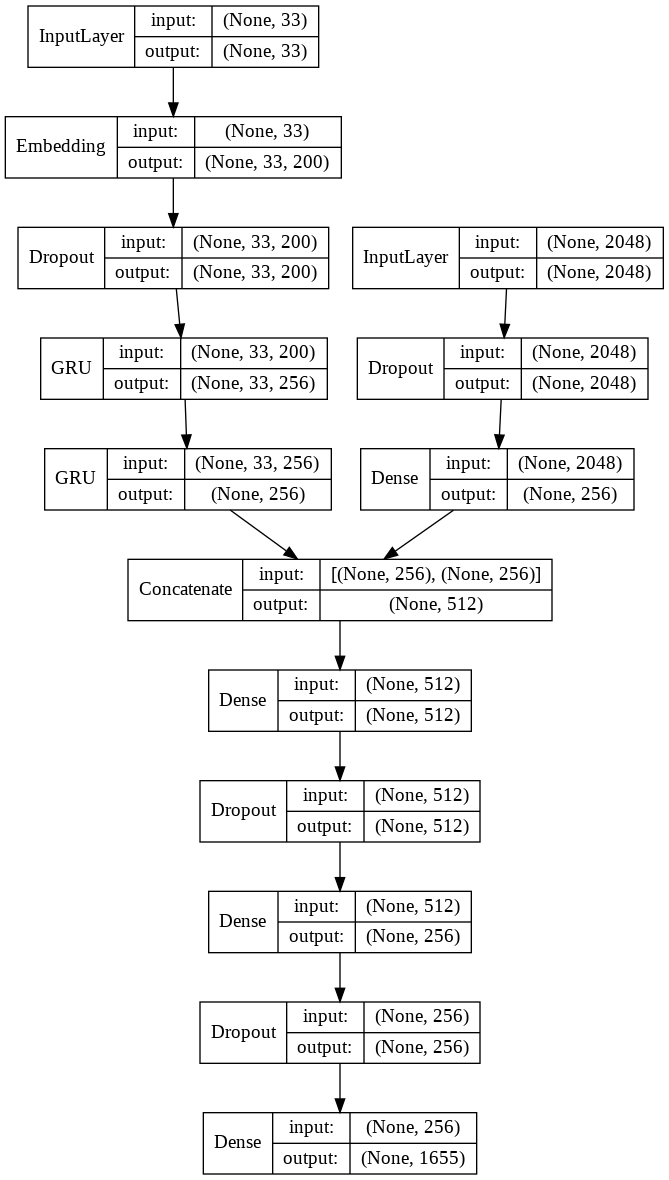

In [ ]:
plot_model(model,show_shapes=True,show_layer_names=False)

Primary Model

In [ ]:
from keras.layers import Bidirectional

In [ ]:
import keras

In [ ]:
emb_dim = 200

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip

--2020-06-28 07:14:53--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2020-06-28 07:14:53--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2020-06-28 07:14:54--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

In [ ]:
!unzip -q /content/glove.6B.zip

In [ ]:
# Load Glove vectors
embeddings_index = {} # empty dictionary
f = open("/content/glove.6B.200d.txt", encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [ ]:
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
vocab_size = len(word_to_idx) + 1
embedding_dim = 200
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in word_to_idx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [ ]:
ip1 = Input(shape = (2048, ))
fe1 = Dropout(0.2)(ip1)
fe2 = Dense(256, activation = 'relu')(fe1)
ip2 = Input(shape = (maxm, ))
se1 = Embedding(vocab_size, emb_dim, mask_zero = True,weights = [embedding_matrix],trainable = False)(ip2)
se2 = Dropout(0.2)(se1)
se3 = (GRU(256,return_sequences=True,return_state=False))(se2)
se4 = (GRU(256))(se3)
decoder1 = concatenate([fe2, se4])
decoder2 = Dense(512, activation = 'relu')(decoder1)
decoder3 = Dropout(0.2)(decoder2)
decoder4 = Dense(256, activation = 'relu')(decoder3)
decoder5 = Dropout(0.2)(decoder4)
outputs = Dense(vocab_size, activation = 'softmax')(decoder5)
model = Model(inputs = [ip1, ip2], outputs = outputs)
#model.layers[2].set_weights([emb_matrix])
#model.layers[2].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = keras.optimizers.Adam(0.0005,decay = 0),metrics = ['accuracy'])

In [ ]:
hist = model.fit([X1,X2],y,epochs = 200,batch_size = 5600)

Epoch 1/200
293370/293370 [==============================] - 61s 209us/step - loss: 5.6601 - accuracy: 0.1106
Epoch 2/200
293370/293370 [==============================] - 59s 202us/step - loss: 4.7372 - accuracy: 0.1884
Epoch 3/200
293370/293370 [==============================] - 59s 203us/step - loss: 4.2730 - accuracy: 0.2239
Epoch 4/200
293370/293370 [==============================] - 60s 204us/step - loss: 3.9871 - accuracy: 0.2446
Epoch 5/200
293370/293370 [==============================] - 60s 205us/step - loss: 3.7875 - accuracy: 0.2613
Epoch 6/200
293370/293370 [==============================] - 59s 202us/step - loss: 3.6492 - accuracy: 0.2736
Epoch 7/200
293370/293370 [==============================] - 59s 200us/step - loss: 3.5388 - accuracy: 0.2839
Epoch 8/200
293370/293370 [==============================] - 58s 198us/step - loss: 3.4509 - accuracy: 0.2934
Epoch 9/200
293370/293370 [==============================] - 58s 199us/step - loss: 3.3736 - accuracy: 0.3010
Epoch 10/2

In [ ]:
 a1 = hist.history['accuracy']
l1 = hist.history['loss']

In [ ]:
a2 = hist.history['accuracy']
l2 = hist.history['loss']

In [ ]:
a3 = hist.history['accuracy']
l3 = hist.history['loss']

In [ ]:
model.save('gruglv200')

In [ ]:
import matplotlib as mpl
mpl.rcParams.update({'font.size':16})

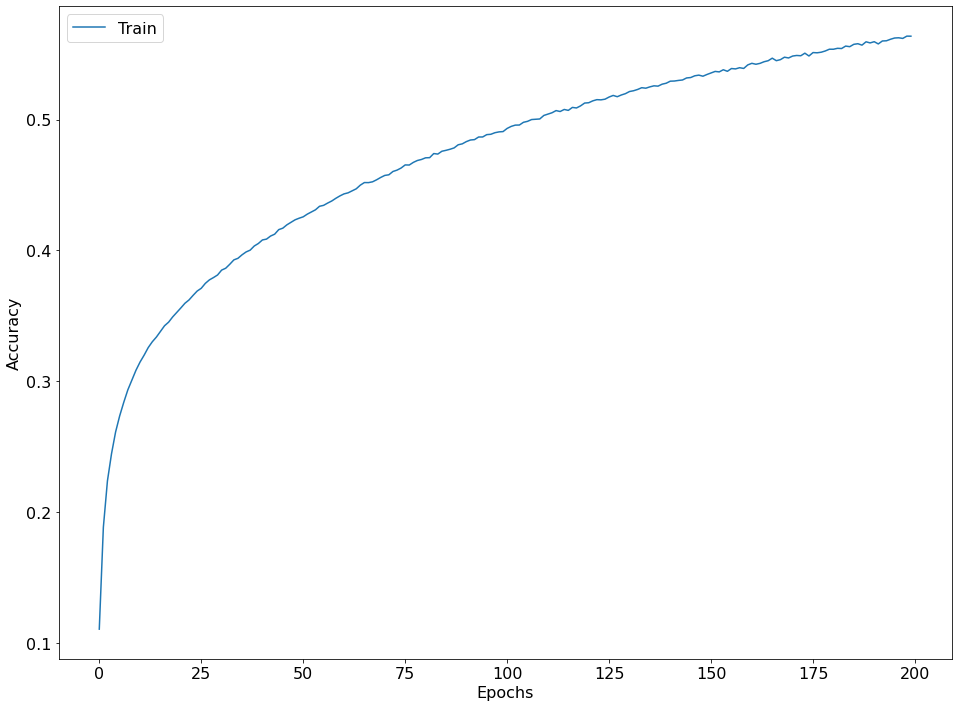

In [ ]:
plt.figure(figsize = (16,12))
plt.plot(np.concatenate([a1]))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(['Train'])

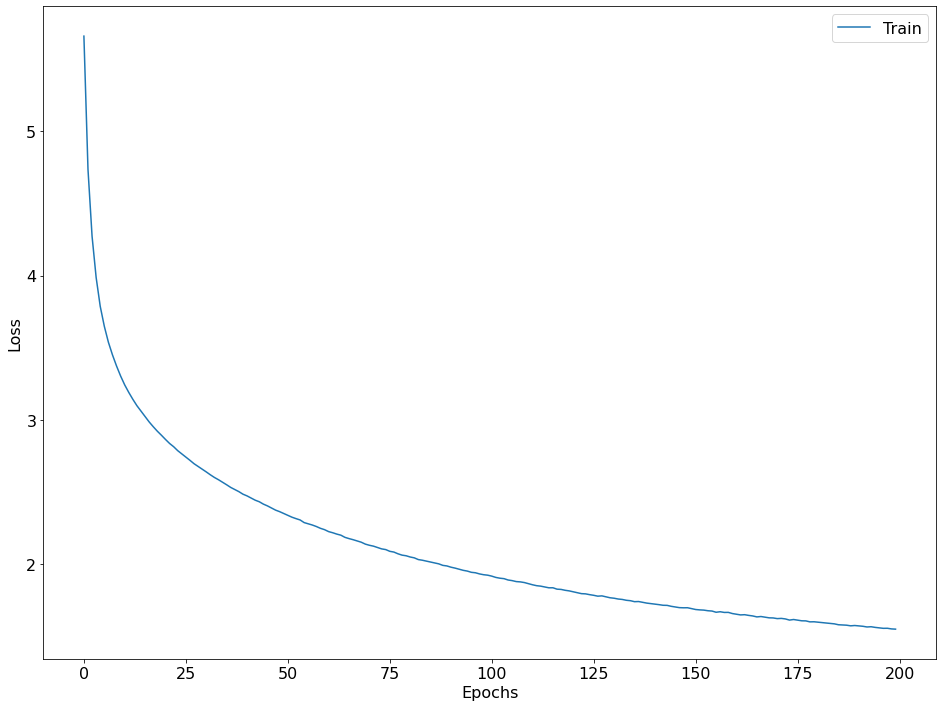

In [ ]:
plt.figure(figsize = (16,12))
plt.plot(np.concatenate([l1]))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train'])